In [51]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

# local Module
import pre_processing_funcs as pre

In [2]:
df = pd.read_csv("data/cleaned_train.csv")
df.head()

,Promotion Name,Store Kind,Is Recyclable?,Grocery Area,Meat Area,Cost,Marriage,Gender,Children,Degree,...,Min. Person Yearly Income,Amenities Score,Family Expenses,Store Efficiency,Promotion Name Length,Store Kind Length,Promotion Frequency,Income Level,Price Tier,Order Popularity
0,Dimes Off,Deluxe,True,2037.64,323.00,602.76,Single,Female,4,bachelors degree,...,10000.00,5,2000.00,3082.09,9,6,539,Low,High Price,368
1,Budget Bargains,Supermarket,False,2049.72,305.02,708.66,Single,Female,3,bachelors degree,...,50000.00,0,12500.00,2259.37,15,11,615,Middle,High Price,3243
2,Shelf Emptiers,Supermarket,True,1322.21,348.85,564.26,Married,Male,2,high school degree,...,30000.00,1,7500.00,4953.66,14,11,393,Middle,High Price,431
3,Sale Winners,Deluxe,False,1872.19,395.95,519.76,Married,Female,5,bachelors degree,...,50000.00,5,7142.86,4038.71,12,6,438,Middle,High Price,3604
4,Weekend Discount,Supermarket,True,1236.07,293.95,364.16,Single,Male,4,high school degree,...,30000.00,1,6000.00,2649.52,16,11,1085,Middle,High Price,106


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28227 entries, 0 to 28226
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28227 non-null  object 
 1   Store Kind                 28227 non-null  object 
 2   Is Recyclable?             28227 non-null  bool   
 3   Grocery Area               28227 non-null  float64
 4   Meat Area                  28227 non-null  float64
 5   Cost                       28227 non-null  float64
 6   Marriage                   28227 non-null  object 
 7   Gender                     28227 non-null  object 
 8   Children                   28227 non-null  int64  
 9   Degree                     28227 non-null  object 
 10  Work                       28227 non-null  object 
 11  Store Code                 28227 non-null  object 
 12  Country ISO2               28227 non-null  object 
 13  Order Brand                28227 non-null  obj

In [4]:
df.head()

,Promotion Name,Store Kind,Is Recyclable?,Grocery Area,Meat Area,Cost,Marriage,Gender,Children,Degree,...,Min. Person Yearly Income,Amenities Score,Family Expenses,Store Efficiency,Promotion Name Length,Store Kind Length,Promotion Frequency,Income Level,Price Tier,Order Popularity
0,Dimes Off,Deluxe,True,2037.64,323.00,602.76,Single,Female,4,bachelors degree,...,10000.00,5,2000.00,3082.09,9,6,539,Low,High Price,368
1,Budget Bargains,Supermarket,False,2049.72,305.02,708.66,Single,Female,3,bachelors degree,...,50000.00,0,12500.00,2259.37,15,11,615,Middle,High Price,3243
2,Shelf Emptiers,Supermarket,True,1322.21,348.85,564.26,Married,Male,2,high school degree,...,30000.00,1,7500.00,4953.66,14,11,393,Middle,High Price,431
3,Sale Winners,Deluxe,False,1872.19,395.95,519.76,Married,Female,5,bachelors degree,...,50000.00,5,7142.86,4038.71,12,6,438,Middle,High Price,3604
4,Weekend Discount,Supermarket,True,1236.07,293.95,364.16,Single,Male,4,high school degree,...,30000.00,1,6000.00,2649.52,16,11,1085,Middle,High Price,106


In [52]:
target = "Cost"
X = df.drop(columns=target)
y = df[target]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
ord_categorical_columns = df.select_dtypes("object").drop(columns=['Marriage', 'Gender']).columns

hot_categorical_columns = ['Marriage', 'Gender', 'Is Recyclable?', "Income Level", "Price Tier"]

numeric_columns = X.select_dtypes("float").columns

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), ord_categorical_columns),
        ('ohe', OneHotEncoder(), hot_categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [56]:
model = make_pipeline(
    preprocessor,
    DecisionTreeRegressor(max_depth=16, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', RobustScaler(),
                                                  Index(['Grocery Area', 'Meat Area', 'Gross Weight', 'Package Weight',
       'Min. Person Yearly Income', 'Family Expenses', 'Store Efficiency'],
      dtype='object'))])

In [57]:
# Check if the model fitted well or not
predictions = model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

30.34461151439718

In [58]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

60.514139085534296

In [59]:
rfmodel = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', RobustScaler(),
                                                  Index(['Grocery Area', 'Meat Area', 'Gross Weight', 'Package Weight',
       'Min. Person Yearly Income', 'Family Expenses', 'Store Efficiency'],
      dtype='object'))])

In [60]:
# Check if the model fitted well or not
predictions = rfmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

28.13340275271794

In [61]:
predictions = rfmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

50.92521347156512

In [15]:
X_train.columns

Index(['Promotion Name', 'Store Kind', 'Is Recyclable?', 'Grocery Area',
       'Meat Area', 'Marriage', 'Gender', 'Children', 'Degree', 'Work',
       'Store Code', 'Country ISO2', 'Order Brand', 'Order', 'Department',
       'Gross Weight', 'Package Weight', 'Min. Person Yearly Income',
       'Amenities Score', 'Family Expenses', 'Store Efficiency',
       'Promotion Name Length', 'Store Kind Length', 'Promotion Frequency',
       'Income Level', 'Price Tier', 'Order Popularity'],
      dtype='object')

In [16]:
rfmodel.named_steps["randomforestregressor"].feature_importances_.round(4)

array([4.782e-01, 3.120e-02, 4.200e-03, 3.400e-03, 1.016e-01, 9.710e-02,
       7.500e-03, 6.000e-03, 4.900e-03, 7.000e-04, 1.000e-04, 8.000e-04,
       8.000e-04, 1.300e-03, 1.000e-03, 6.000e-04, 6.000e-04, 3.000e-04,
       2.000e-04, 5.000e-04, 1.000e-04, 1.000e-04, 9.970e-02, 1.234e-01,
       8.400e-03, 4.800e-03, 3.000e-03, 8.400e-03, 1.120e-02])

In [62]:
exmodel = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)
exmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', RobustScaler(),
                                                  Index(['Grocery Area', 'Meat Area', 'Gross Weight', 'Package Weight',
       'Min. Person Yearly Income', 'Family Expenses', 'Store Efficiency'],
      dtype='object'))])

In [63]:
# Check if the model fitted well or not
predictions = exmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

24.29475683975747

In [64]:
predictions = exmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

47.47553182701925

<AxesSubplot:>

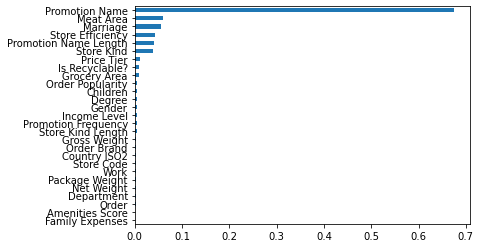

In [71]:

pd.Series(exmodel.named_steps["extratreesregressor"].feature_importances_,
         index=X_train.columns).sort_values().plot(kind="barh")

In [187]:
# iterate over 25 to 500 step 25 on number of estimators for model
i=1
for n in range(25, 501, 25):
    bag = make_pipeline(
        preprocessor,
        BaggingRegressor(n_estimators=n, n_jobs=-1, random_state=42)
    )
    bag.fit(X_train, y_train)
    
    predictions = bag.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, predictions))
    
    predictions = bag.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"Step: {i}/{500//25}, Train: {train_rmse}, Test {test_rmse} FOR {n} estmators")
    i+=1

Step: 1/20, Train: 20.738205946089984, Test 53.749584156167415 FOR 25 estmators
Step: 2/20, Train: 19.74949029168199, Test 53.33527254167905 FOR 50 estmators
Step: 3/20, Train: 19.49867390333684, Test 53.195560459734494 FOR 75 estmators
Step: 4/20, Train: 19.300728045957193, Test 52.913703485838845 FOR 100 estmators
Step: 5/20, Train: 19.248918105310146, Test 52.87113557309438 FOR 125 estmators


KeyboardInterrupt: 

In [46]:
# Check if the model fitted well or not
predictions = bag.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

19.196096765531266

In [47]:
# Check if the model fitted well or not
predictions = bag.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

51.385483385146834

In [95]:
cat = CatBoostRegressor(
    iterations=500,
    random_state=42,
    loss_function='RMSE',
)
cat.fit(
    X_train,
    y_train,
    cat_features=list(X_train.select_dtypes("object").columns),
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.126783
0:	learn: 143.7638921	test: 144.6641599	best: 144.6641599 (0)	total: 209ms	remaining: 1m 44s
1:	learn: 132.2142296	test: 132.8335514	best: 132.8335514 (1)	total: 276ms	remaining: 1m 8s
2:	learn: 123.4039245	test: 123.5488701	best: 123.5488701 (2)	total: 321ms	remaining: 53.1s
3:	learn: 115.3010985	test: 115.1629405	best: 115.1629405 (3)	total: 371ms	remaining: 46s
4:	learn: 108.8596798	test: 108.4549824	best: 108.4549824 (4)	total: 435ms	remaining: 43.1s
5:	learn: 102.8360585	test: 102.1193144	best: 102.1193144 (5)	total: 490ms	remaining: 40.4s
6:	learn: 97.7802599	test: 96.8296328	best: 96.8296328 (6)	total: 542ms	remaining: 38.2s
7:	learn: 93.4167377	test: 92.2745212	best: 92.2745212 (7)	total: 589ms	remaining: 36.3s
8:	learn: 90.0461759	test: 88.7138744	best: 88.7138744 (8)	total: 635ms	remaining: 34.7s
9:	learn: 87.3700757	test: 85.8790396	best: 85.8790396 (9)	total: 687ms	remaining: 33.7s
10:	learn: 84.2957522	test: 82.5645578	best: 82.5645578 (10)	to

91:	learn: 58.6968431	test: 55.9995960	best: 55.9995960 (91)	total: 4.85s	remaining: 21.5s
92:	learn: 58.6880884	test: 55.9964644	best: 55.9964644 (92)	total: 4.89s	remaining: 21.4s
93:	learn: 58.6703894	test: 55.9973731	best: 55.9964644 (92)	total: 4.94s	remaining: 21.3s
94:	learn: 58.6472075	test: 55.9654113	best: 55.9654113 (94)	total: 5s	remaining: 21.3s
95:	learn: 58.6046570	test: 55.9231748	best: 55.9231748 (95)	total: 5.04s	remaining: 21.2s
96:	learn: 58.5642467	test: 55.8911839	best: 55.8911839 (96)	total: 5.09s	remaining: 21.2s
97:	learn: 58.4981314	test: 55.8343740	best: 55.8343740 (97)	total: 5.14s	remaining: 21.1s
98:	learn: 58.4083604	test: 55.7473594	best: 55.7473594 (98)	total: 5.19s	remaining: 21s
99:	learn: 58.3657152	test: 55.7160126	best: 55.7160126 (99)	total: 5.23s	remaining: 20.9s
100:	learn: 58.2100465	test: 55.5703597	best: 55.5703597 (100)	total: 5.29s	remaining: 20.9s
101:	learn: 58.2032873	test: 55.5729489	best: 55.5703597 (100)	total: 5.34s	remaining: 20.8s


180:	learn: 54.9500334	test: 53.4275290	best: 53.4275290 (180)	total: 9.54s	remaining: 16.8s
181:	learn: 54.9274179	test: 53.4194615	best: 53.4194615 (181)	total: 9.59s	remaining: 16.8s
182:	learn: 54.9243501	test: 53.4195011	best: 53.4194615 (181)	total: 9.65s	remaining: 16.7s
183:	learn: 54.8995966	test: 53.4080935	best: 53.4080935 (183)	total: 9.71s	remaining: 16.7s
184:	learn: 54.8749109	test: 53.4037157	best: 53.4037157 (184)	total: 9.77s	remaining: 16.6s
185:	learn: 54.8315620	test: 53.4077320	best: 53.4037157 (184)	total: 9.84s	remaining: 16.6s
186:	learn: 54.7898037	test: 53.4155842	best: 53.4037157 (184)	total: 9.9s	remaining: 16.6s
187:	learn: 54.7701745	test: 53.4255487	best: 53.4037157 (184)	total: 9.96s	remaining: 16.5s
188:	learn: 54.7520017	test: 53.4281281	best: 53.4037157 (184)	total: 10s	remaining: 16.5s
189:	learn: 54.7420883	test: 53.4268116	best: 53.4037157 (184)	total: 10.1s	remaining: 16.4s
190:	learn: 54.7089489	test: 53.4527396	best: 53.4037157 (184)	total: 10.

273:	learn: 52.6936581	test: 52.3941022	best: 52.3941022 (273)	total: 14.6s	remaining: 12s
274:	learn: 52.6378652	test: 52.3535744	best: 52.3535744 (274)	total: 14.6s	remaining: 12s
275:	learn: 52.5968847	test: 52.3136884	best: 52.3136884 (275)	total: 14.7s	remaining: 11.9s
276:	learn: 52.5855254	test: 52.3054127	best: 52.3054127 (276)	total: 14.7s	remaining: 11.9s
277:	learn: 52.5314290	test: 52.2747996	best: 52.2747996 (277)	total: 14.8s	remaining: 11.8s
278:	learn: 52.5299847	test: 52.2740162	best: 52.2740162 (278)	total: 14.9s	remaining: 11.8s
279:	learn: 52.5260663	test: 52.2738338	best: 52.2738338 (279)	total: 14.9s	remaining: 11.7s
280:	learn: 52.4814140	test: 52.2995992	best: 52.2738338 (279)	total: 15s	remaining: 11.7s
281:	learn: 52.4578244	test: 52.2829491	best: 52.2738338 (279)	total: 15s	remaining: 11.6s
282:	learn: 52.3897776	test: 52.2452204	best: 52.2452204 (282)	total: 15.1s	remaining: 11.6s
283:	learn: 52.3879174	test: 52.2445509	best: 52.2445509 (283)	total: 15.1s	re

363:	learn: 50.6244544	test: 51.6167943	best: 51.6167943 (363)	total: 19.7s	remaining: 7.36s
364:	learn: 50.6193478	test: 51.6164754	best: 51.6164754 (364)	total: 19.7s	remaining: 7.3s
365:	learn: 50.6141966	test: 51.6146831	best: 51.6146831 (365)	total: 19.8s	remaining: 7.25s
366:	learn: 50.5628860	test: 51.5990139	best: 51.5990139 (366)	total: 19.9s	remaining: 7.2s
367:	learn: 50.5534608	test: 51.6040557	best: 51.5990139 (366)	total: 19.9s	remaining: 7.15s
368:	learn: 50.5414472	test: 51.6191085	best: 51.5990139 (366)	total: 20s	remaining: 7.09s
369:	learn: 50.5000476	test: 51.6030250	best: 51.5990139 (366)	total: 20s	remaining: 7.04s
370:	learn: 50.4958207	test: 51.6031395	best: 51.5990139 (366)	total: 20.1s	remaining: 6.99s
371:	learn: 50.4645787	test: 51.6063678	best: 51.5990139 (366)	total: 20.2s	remaining: 6.93s
372:	learn: 50.4611460	test: 51.6039833	best: 51.5990139 (366)	total: 20.2s	remaining: 6.88s
373:	learn: 50.4558236	test: 51.6091805	best: 51.5990139 (366)	total: 20.3s	

455:	learn: 48.6553224	test: 51.1008221	best: 51.0997583 (453)	total: 25.1s	remaining: 2.42s
456:	learn: 48.6022237	test: 51.1279668	best: 51.0997583 (453)	total: 25.2s	remaining: 2.37s
457:	learn: 48.5811523	test: 51.1342496	best: 51.0997583 (453)	total: 25.2s	remaining: 2.31s
458:	learn: 48.5668119	test: 51.1361710	best: 51.0997583 (453)	total: 25.3s	remaining: 2.26s
459:	learn: 48.5445604	test: 51.1355113	best: 51.0997583 (453)	total: 25.3s	remaining: 2.2s
460:	learn: 48.5396034	test: 51.1347025	best: 51.0997583 (453)	total: 25.4s	remaining: 2.15s
461:	learn: 48.5278281	test: 51.1319659	best: 51.0997583 (453)	total: 25.4s	remaining: 2.09s
462:	learn: 48.4953190	test: 51.1570083	best: 51.0997583 (453)	total: 25.5s	remaining: 2.04s
463:	learn: 48.4776914	test: 51.1572688	best: 51.0997583 (453)	total: 25.6s	remaining: 1.98s
464:	learn: 48.4713119	test: 51.1534316	best: 51.0997583 (453)	total: 25.6s	remaining: 1.93s
465:	learn: 48.4585603	test: 51.1494344	best: 51.0997583 (453)	total: 2

In [96]:
np.sqrt(mean_squared_error(y_train, cat.predict(X_train)))

47.75860505663966

In [97]:
np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

51.09975770960958

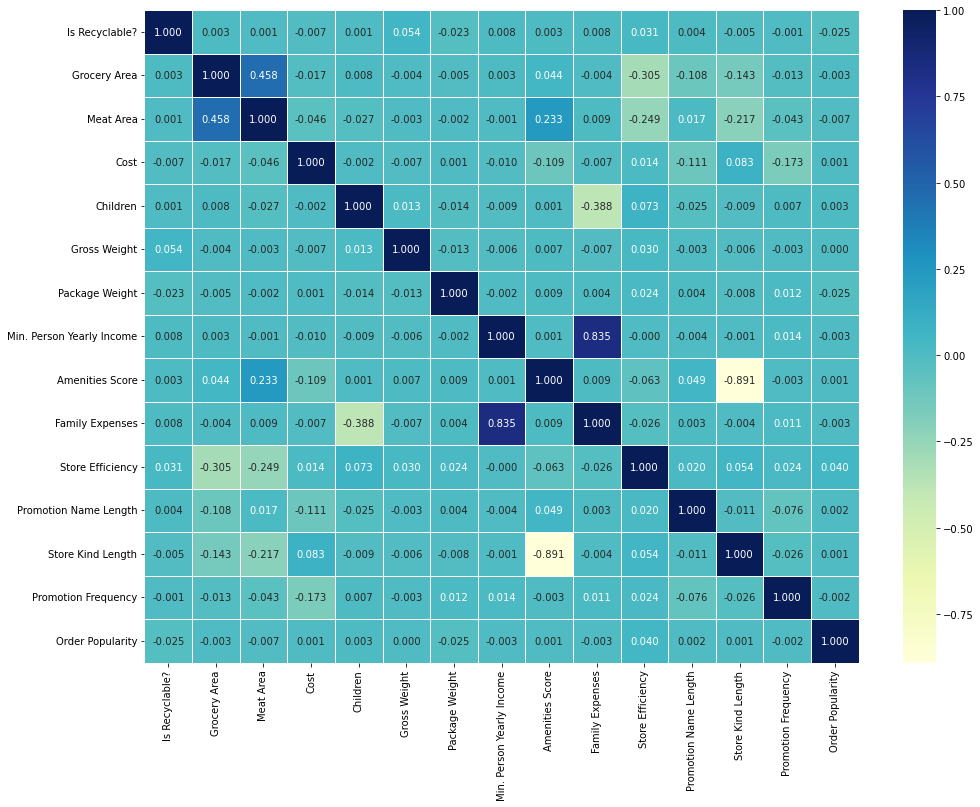

In [21]:
plt.figure(figsize=(16, 12)) 
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

## Try Lazypredict

In [201]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [202]:
reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  2%|█▉                                                                                 | 1/42 [00:00<00:38,  1.06it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11951398275585512, 'Adjusted R-Squared': 0.11496731350726541, 'RMSE': 148.32596671558773, 'Time taken': 0.9390995502471924}


  7%|█████▉                                                                             | 3/42 [00:02<00:32,  1.21it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.883198461036519, 'Adjusted R-Squared': 0.8825953191864583, 'RMSE': 54.0231916402976, 'Time taken': 1.737999439239502}
{'Model': 'BayesianRidge', 'R-Squared': 0.016954023854418576, 'Adjusted R-Squared': 0.011877753678453229, 'RMSE': 156.72665721884587, 'Time taken': 0.1269996166229248}


 14%|███████████▊                                                                       | 6/42 [00:03<00:12,  2.94it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8129080435696533, 'Adjusted R-Squared': 0.8119419348202801, 'RMSE': 68.37282338929582, 'Time taken': 0.32084035873413086}
{'Model': 'DummyRegressor', 'R-Squared': -0.00035584667892929467, 'Adjusted R-Squared': -0.005521501870113132, 'RMSE': 158.1004889993646, 'Time taken': 0.061963796615600586}
{'Model': 'ElasticNet', 'R-Squared': 0.013369005246233967, 'Adjusted R-Squared': 0.008274222687854604, 'RMSE': 157.01217624156013, 'Time taken': 0.10863113403320312}


 19%|███████████████▊                                                                   | 8/42 [00:04<00:13,  2.44it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.017362691412113218, 'Adjusted R-Squared': 0.012288531520900925, 'RMSE': 156.69407697350522, 'Time taken': 0.9368021488189697}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7490987628790684, 'Adjusted R-Squared': 0.7478031546389496, 'RMSE': 79.17851589353039, 'Time taken': 0.16990327835083008}


 19%|███████████████▊                                                                   | 8/42 [00:09<00:40,  1.20s/it]


KeyboardInterrupt: 

In [ ]:
print(models)

## ExtraTreesRegressor

In [ ]:
# GridSearch for ExtraTree Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2],
}

GS_EXTRA = GridSearchCV(
    ExtraTreesRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_EXTRA.fit(X_train_transformed, y_train)

In [ ]:
GS_EXTRA.best_params_

In [ ]:
EXTRA = GS_EXTRA.best_estimator_
EXTRA

## RandomForestRegressor

In [15]:
# GridSearch for RandomForest Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2,3],
    # 'max_features': ["sqrt", "log2"] add 1 is the default
}

GS_RF = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 8, 16, 32, 64],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': range(100, 501, 100)},
             verbose=1)

In [16]:
GS_RF.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [19]:
RF = GS_RF.best_estimator_
RF

RandomForestRegressor(max_depth=32, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=42)

## BaggingRegressor

In [ ]:
# GridSearch for Bagging Regressor
params = {
    'n_estimators': range(100, 801, 20),
}

BAG_RF = GridSearchCV(
    BaggingRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

BAG_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
BAG_RF.best_params_

In [ ]:
BAG = BAG_RF.best_estimator_
BAG

## XGBRegressor

In [22]:
model = make_pipeline(preprocessor, XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=12, min_split_loss=5))
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', Standar...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
 

In [23]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 52.29


In [ ]:
param_grid = {
    'xgbregressor__learning_rate': [0.01, 0.1],
    'xgbregressor__n_estimators': range(50, 501, 50),
    'xgbregressor__max_depth': [2, 4, 8, 16, 32],
    'xgbregressor__min_split_loss': range(0, 7, 2)
    
}


grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [ ]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## LGBMRegressor

In [24]:
model = make_pipeline(preprocessor, LGBMRegressor())
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 22581, number of used features: 29
[LightGBM] [Info] Start training from score 518.858765


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', StandardScaler(),
                                                  Index(['Grocery Area', 'Meat Area', 'Gross Weight', 'Package Weight',
       'Min. Person Yearly Income', 'Family Expenses', 'Store Efficiency'],
      dtype='object'))

In [25]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 61.68


In [ ]:
param_grid = {
    'lgbmregressor__learning_rate': [0.01, 0.1],
    'lgbmregressor__n_estimators': range(50, 501, 50),
    'lgbmregressor__num_leaves': [31, 45, 61],
    'lgbmregressor__max_depth': [2, 4, 8, 16, 32],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [161]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## Stacking & Boosting

In [27]:
rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

et = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

bag = make_pipeline(
    preprocessor,
    BaggingRegressor(n_estimators=75, n_jobs=-1, random_state=42)
)


#lr = LogisticRegression(random_state=0, max_iter=500, C = 10, penalty= 'l2', solver= 'newton-cg')

#mlp = MLPClassifier(random_state=0, hidden_layer_sizes = (512,) , max_iter=100, early_stopping=True,
              #      solver='adam', learning_rate = 'adaptive', alpha=0.001, activation='relu', batch_size=128)

#gb = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100)

#hgb = HistGradientBoostingClassifier(random_state=0, learning_rate=0.01, l2_regularization=0.001)

#lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=1000, num_leaves=10)

#cat = CatBoostClassifier(n_estimators=1500, learning_rate=0.05, random_state=0, eval_metric= 'MultiClass')

In [50]:
estimators = [
              ('rf', rf),
              ('et', et),
              # ('bag', bag),
             ]

stack_model = StackingRegressor(estimators=estimators, final_estimator=bag)

stack_model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [37]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

32.003467789896284

In [38]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

52.91357827365574

In [32]:
estimators = [
              ('rf', rf),
              ('et', et),
              # ('bag', bag),
             ]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                                              ('ohe',
                                                                               OneHotEncoder(),
                                                                               ['Marriage',
                                                                                'Gender',
                                                                              

In [34]:
# Check if the model fitted well or not
predictions = voting_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

25.514620525696635

In [35]:
predictions = voting_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

48.38512358051683

## Optuna Optimization

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 64),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    
    model = ExtraTreesRegressor(**params, n_jobs=-1, random_state=42)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores=cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring=rmse_scorer)
    positive_scores = (-scores).mean()


    return positive_scores

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
# Print the best hyperparameters and corresponding RMSE
print("Best trial:")
trial = study.best_trial
print("Value (RMSE): {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Extract submissions

In [39]:
samples = pd.read_csv('data/sample_submission.csv')
samples.head()

,ID,Cost
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [40]:
test = pre.pd.read_csv("data/cleaned_test.csv")
test.head()

,Promotion Name,Store Kind,Is Recyclable?,Grocery Area,Meat Area,Marriage,Gender,Children,Degree,Work,...,Min. Person Yearly Income,Amenities Score,Family Expenses,Store Efficiency,Promotion Name Length,Store Kind Length,Promotion Frequency,Income Level,Price Tier,Order Popularity
0,Fantastic Discounts,Gourmet,True,1424.85,308.73,Single,Male,4,partial high school,skilled manual,...,50000.00,5,10000.00,5342.88,19,7,58,Middle,High Price,485
1,Bag Stuffer,Deluxe,False,1735.17,336.59,Married,Female,3,graduate degree,professional,...,70000.00,5,14000.00,838.13,11,6,361,High,High Price,2337
2,Pick Your Savings,Deluxe,False,2038.11,321.26,Single,Female,3,partial high school,management,...,130000.00,5,32500.00,644.92,17,6,291,High,High Price,1292
3,Price Winners,Deluxe,False,1871.16,394.58,Single,Male,3,partial high school,manual,...,10000.00,5,2500.00,3084.95,13,6,665,Low,High Price,476
4,Dollar Days,Supermarket,False,1320.15,348.85,Single,Male,2,high school degree,manual,...,30000.00,1,10000.00,1969.03,11,11,174,Middle,High Price,308


In [41]:
test.isna().sum()

Promotion Name               0
Store Kind                   0
Is Recyclable?               0
Grocery Area                 0
Meat Area                    0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Gross Weight                 0
Package Weight               0
Min. Person Yearly Income    0
Amenities Score              0
Family Expenses              0
Store Efficiency             0
Promotion Name Length        0
Store Kind Length            0
Promotion Frequency          0
Income Level                 0
Price Tier                   0
Order Popularity             0
dtype: int64

In [42]:
y_sub_pred = exmodel.predict(test)

In [43]:
samples["Cost"] = y_sub_pred

In [44]:
samples.to_csv("data/submission.csv", index=False)